In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
import pickle
from matplotlib import style
style.use('fivethirtyeight')
from skimage import io, exposure

In [2]:
data_dir = 'C:/Users/krman/Desktop/CV_Project/'
train_path = 'C:/Users/krman/Desktop/CV_Project/Train'
test_path = 'C:/Users/krman/Desktop/CV_Project/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory',41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Step 1: Exploratory visualization of dataset ##
* Load the dataset and display histograam 

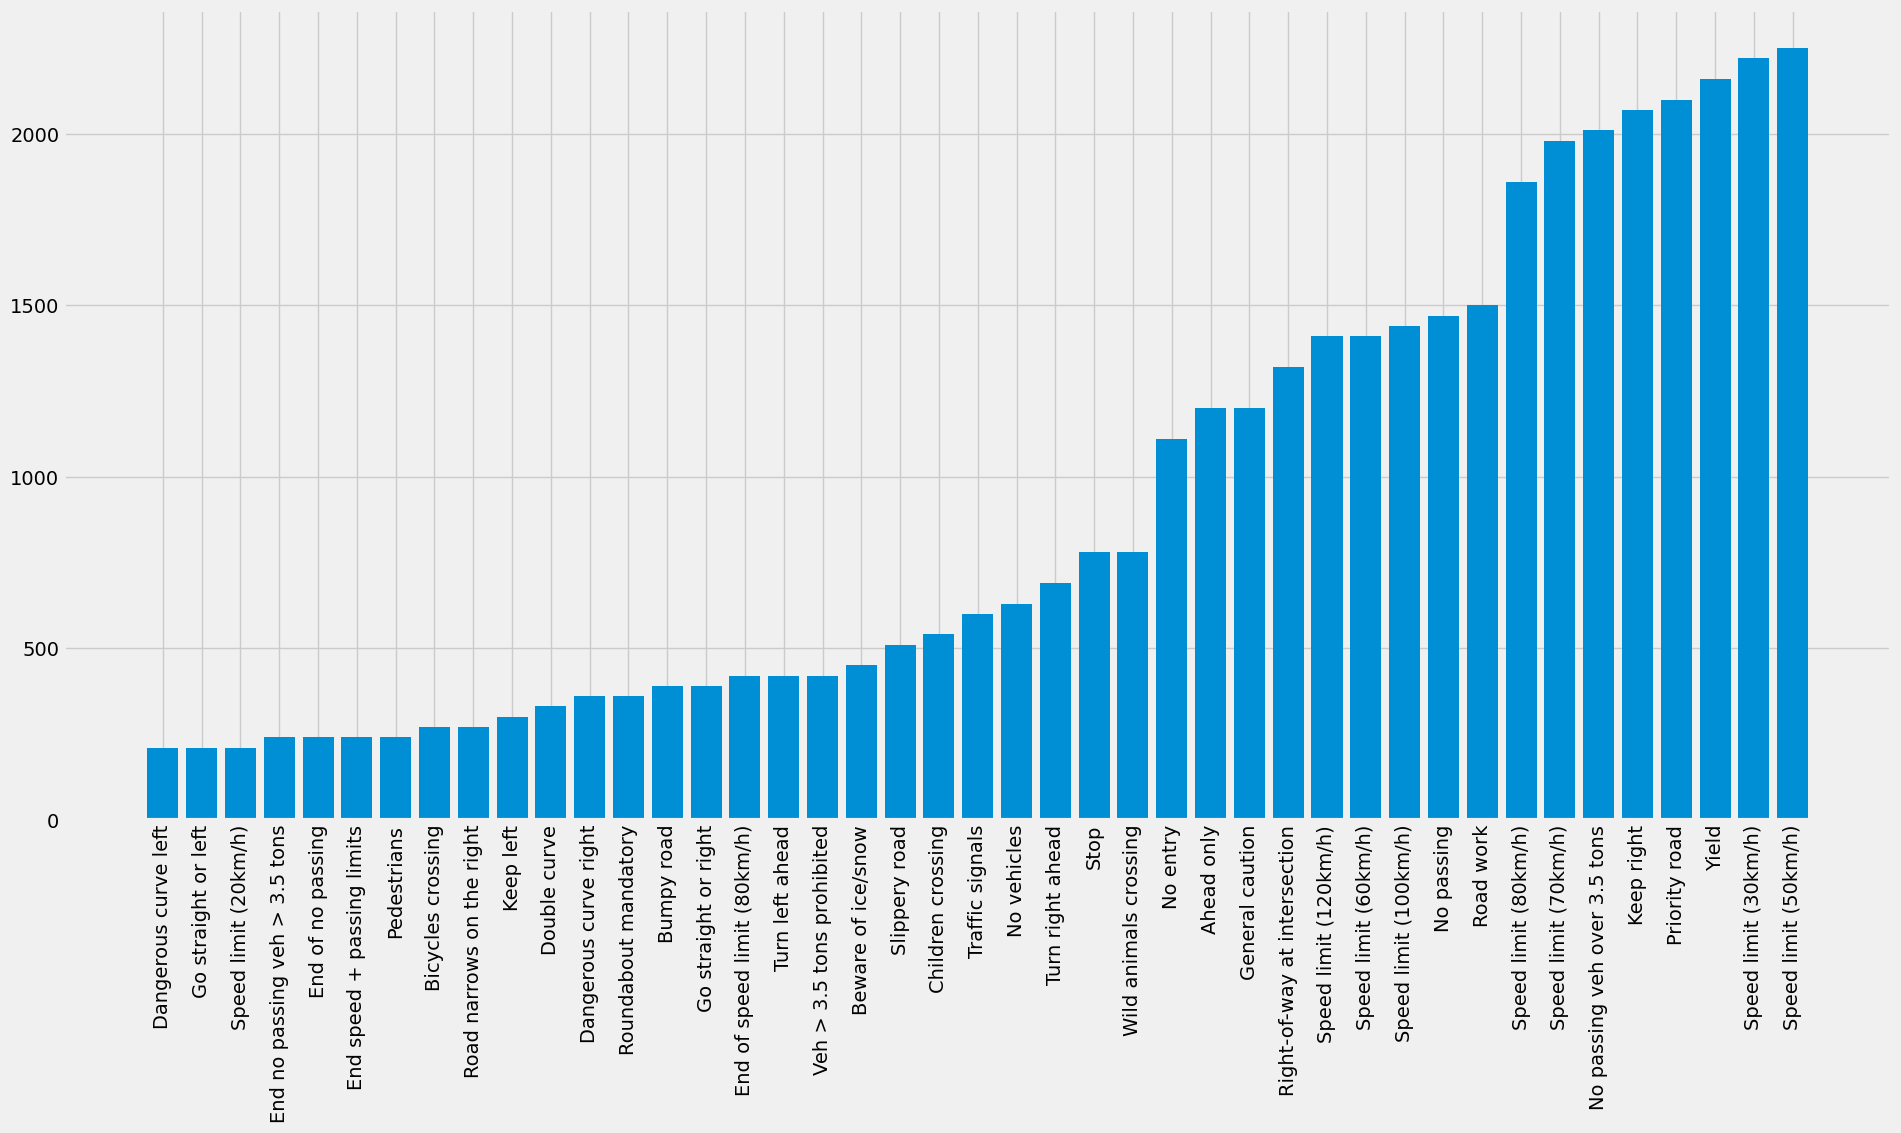

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Dataset Discussion and Observations ##

### Size of Dataset
* The GTSRB dataset provided is far from enough to allow a deep network to learn its features 
* So the dataset needs to extended to an agreeable level as we are going to train it from scratch 

### Distribution of Classes
* The class ID with ID 2 Speed limit 50 kmph has the highest number of images 2010 while there are classes with less than 180 images. 
* Balancing the dataset becomes paramount as we want the performance to be uniform across classes.

### Image Quality
* The images in all datasets especially test set are dark or bright , so imaage processing may have to be done additional to normalization and scaling.



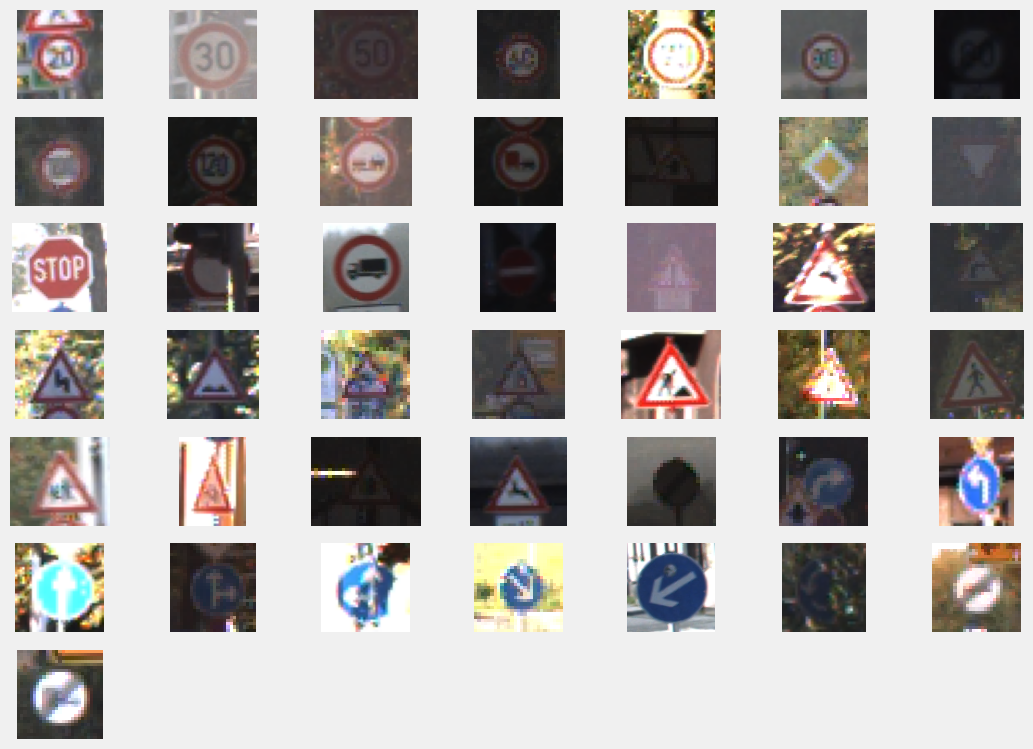

In [6]:
fig = plt.figure(figsize=(12, 9))
displayed_images = 0
for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    img_name = images[0]
    try:
        image_path = os.path.join(path, img_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

        ax = fig.add_subplot(7, 7, displayed_images + 1)
        ax.imshow(image)
        ax.axis('off')
        
        displayed_images += 1
        
        if displayed_images >= NUM_CATEGORIES:
            break  # Stop displaying after reaching the desired number
        
    except Exception as e:
        print(f"Error in {img_name}: {e}")

In [7]:
train_new = "C:/Users/krman/Desktop/CV_Project/Train_New/"
for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    path_new = train_new + str(i)
    
    if not os.path.exists(path_new):
        os.makedirs(path_new)
        
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            kernel_size = (3, 3)
            sigma_x = 0
            blurred_img = cv2.GaussianBlur(image_rgb, kernel_size, sigma_x)
            blurred_img_rgb = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(path_new + '/' + img, blurred_img_rgb)

        except:
            print("Error in " + img)
            
train_path = 'C:/Users/krman/Desktop/CV_Project/Train_New'

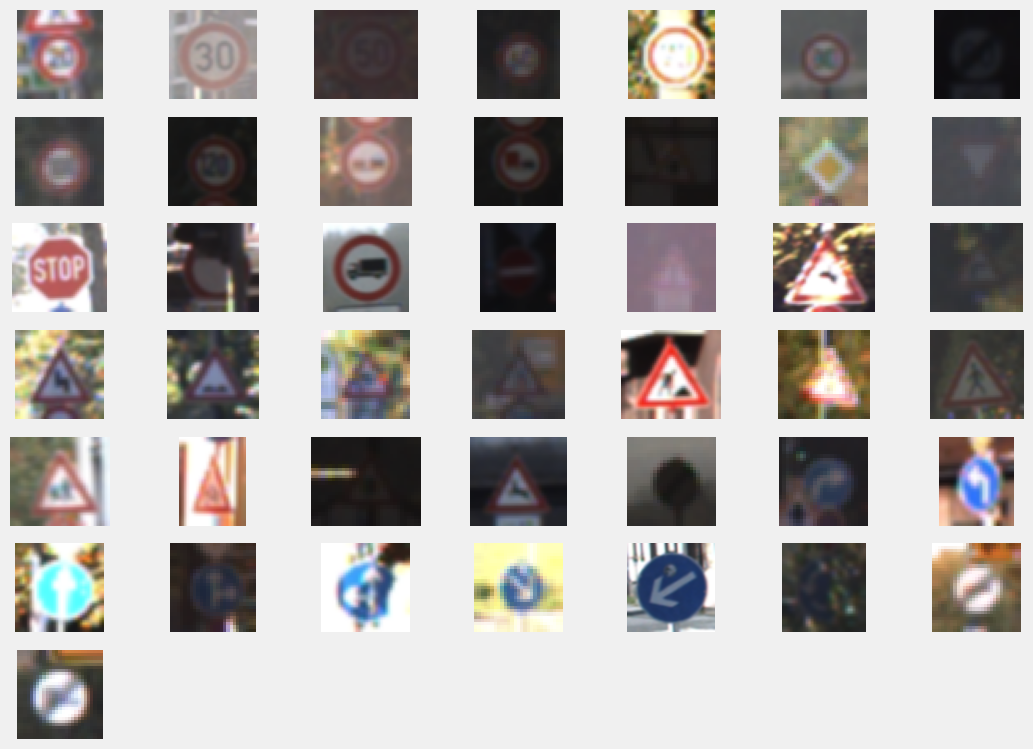

In [8]:
fig = plt.figure(figsize=(12, 9))
displayed_images = 0
for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train_New/' + str(i)
    images = os.listdir(path)
    img_name = images[0]
    try:
        image_path = os.path.join(path, img_name)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax = fig.add_subplot(7, 7, displayed_images + 1)
        ax.imshow(image_rgb)
        ax.axis('off')
        
        displayed_images += 1
        
        if displayed_images >= NUM_CATEGORIES:
            break  # Stop displaying after reaching the desired number
        
    except Exception as e:
        print(f"Error in {img_name}: {e}")

In [9]:
for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)      
    images = os.listdir(path)
    path_new = train_new + str(i)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            clahe_img = exposure.equalize_adapthist(image_rgb,clip_limit = 0.1)  
            clahe_img_uint8 = (clahe_img * 255).astype(np.uint8)
            cv2.imwrite(path_new + '/' + img,cv2.cvtColor(clahe_img_uint8, cv2.COLOR_BGR2RGB))

        except:
            print("Error in " + img)
            

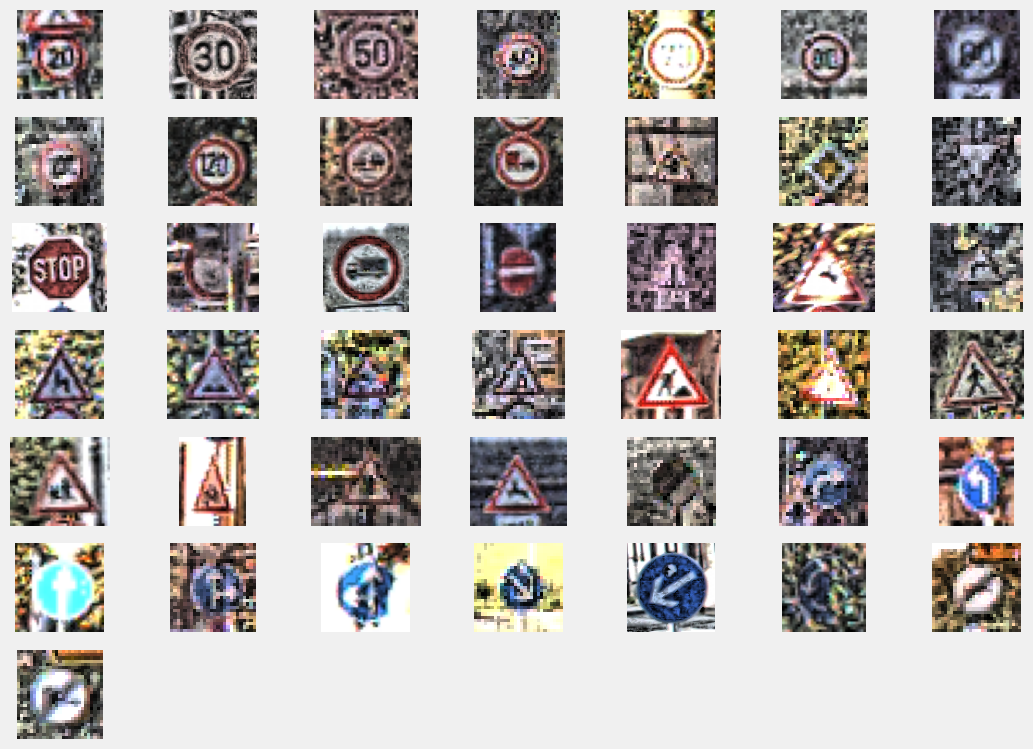

In [10]:
fig = plt.figure(figsize=(12, 9))
displayed_images = 0
for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train_New/' + str(i)
    images = os.listdir(path)
    img_name = images[0]
    try:
        image_path = os.path.join(path, img_name)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax = fig.add_subplot(7, 7, displayed_images + 1)
        ax.imshow(image_rgb)
        ax.axis('off')
        
        displayed_images += 1
        
        if displayed_images >= NUM_CATEGORIES:
            break  # Stop displaying after reaching the desired number
        
    except Exception as e:
        print(f"Error in {img_name}: {e}")

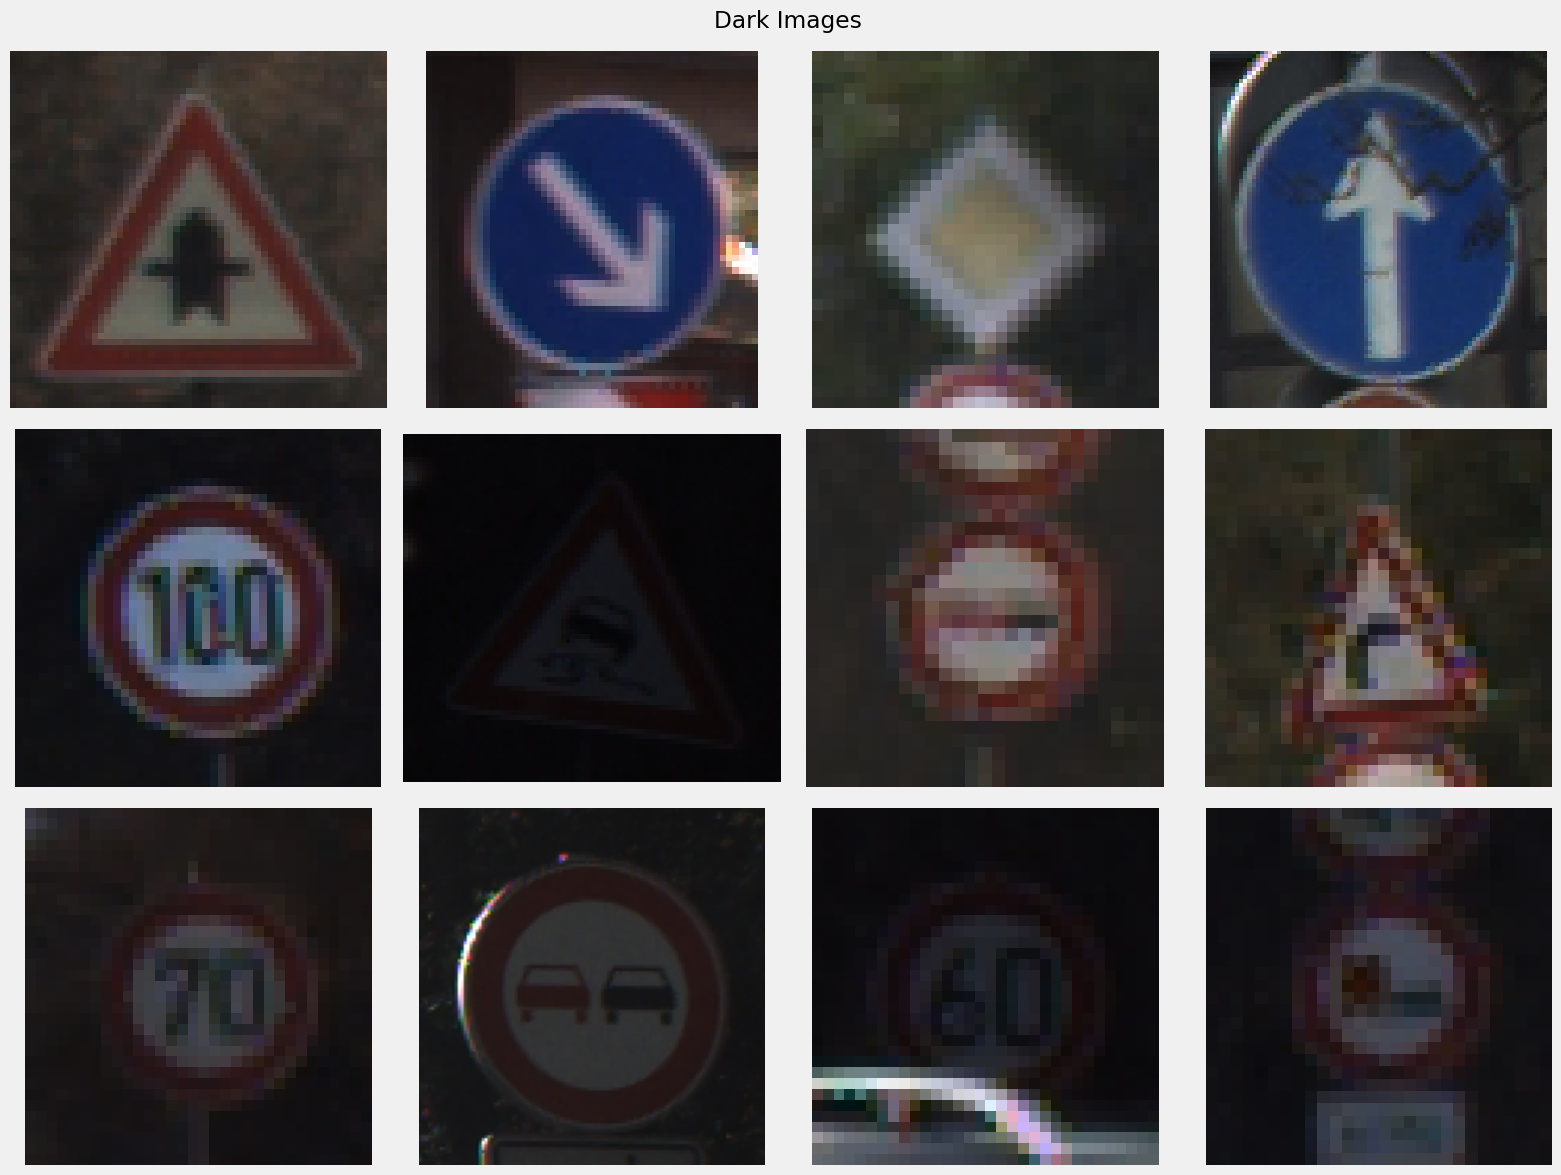

In [31]:
def save_dark_images(input_dir, output_dir,output_dir2, brightness_threshold):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_dir2, exist_ok=True)
    
    image_files = os.listdir(input_dir) # List all image files in the input directory

    for img_file in image_files:
        img_path = os.path.join(input_dir, img_file)
        if is_dark_image(img_path, brightness_threshold):
            dark_img = cv2.imread(img_path)
            dark_output_path = os.path.join(output_dir, img_file)
            cv2.imwrite(dark_output_path, dark_img)
            # ax[i,j].set_title("Dark")
            # print(f"Dark image saved: {dark_output_path}")
        else:
            normal_img = cv2.imread(img_path)
            normal_output_path = os.path.join(output_dir2, img_file)
            cv2.imwrite(normal_output_path, normal_img)
            # print(f"Normal image saved: {normal_output_path}")

def is_dark_image(image_path, threshold):
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert image to grayscale
    avg_intensity = gray_img.mean() # Calculate average pixel intensity
    return avg_intensity < threshold

input_directory = 'Test_original/'
output_directory = 'dark_images/'
output_directory2 = 'Test/'

brightness_threshold = 69 # Set brightness threshold

save_dark_images(input_directory, output_directory,output_directory2, brightness_threshold) # Save dark images from the input directory to the output directory


image_files = [f for f in os.listdir("dark_images/") if f.endswith('.jpg') or f.endswith('.png')]
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(16, 12)
fig.suptitle("Dark Images")
for idx, image_file in enumerate(image_files[:12]):
    img_path = os.path.join("dark_images/", image_file)
    img = Image.open(img_path)
    ax[idx // 4, idx % 4].imshow(img)
    ax[idx // 4, idx % 4].axis('off')

plt.tight_layout()
plt.show()

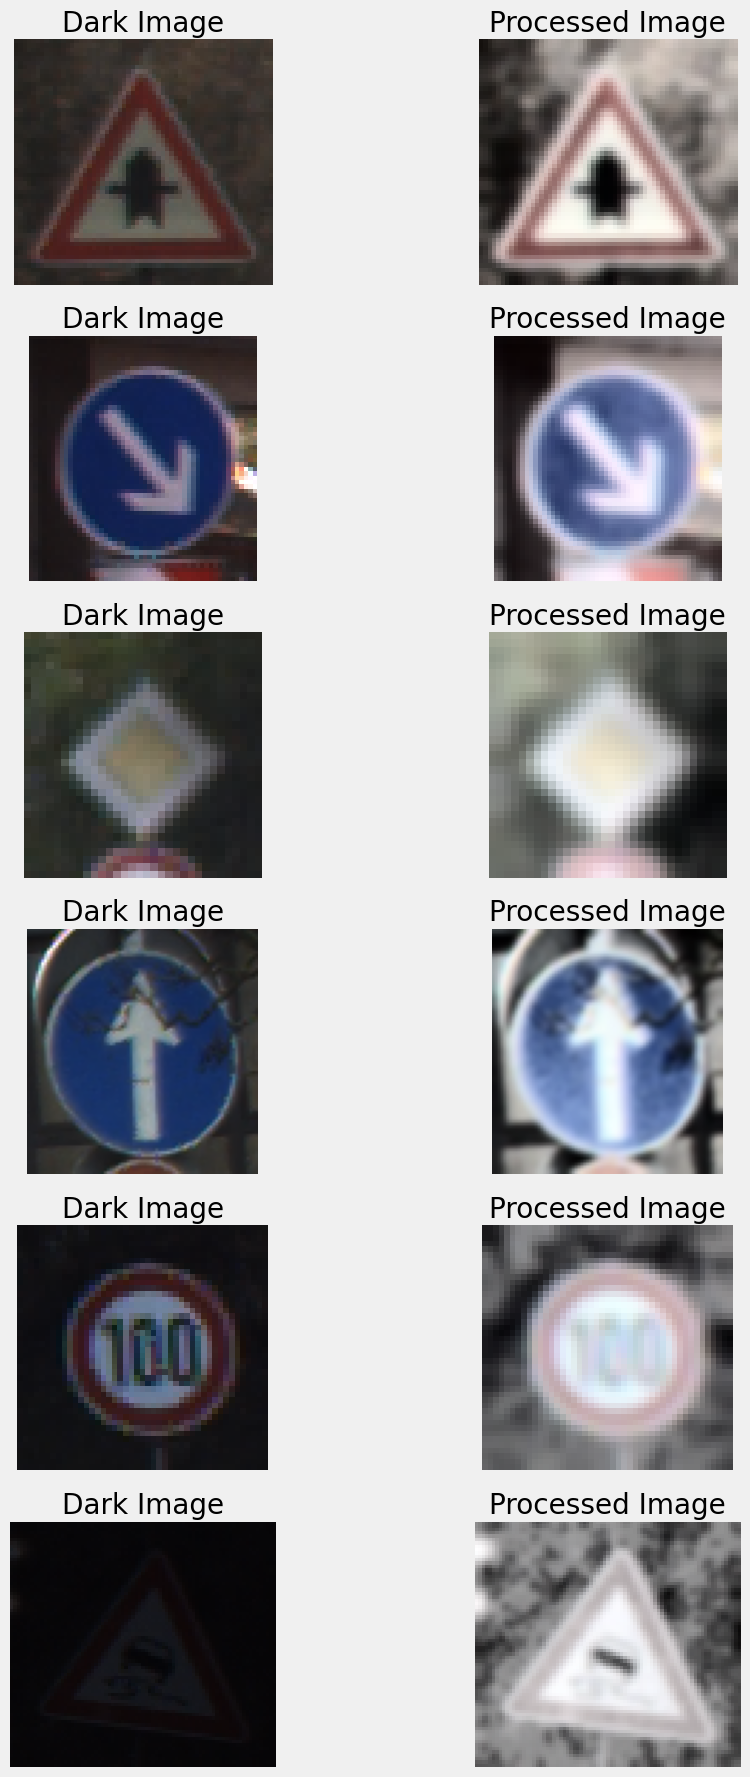

In [32]:
def enhance_brightness_and_reduce_noise(image_path, output_dir):
    # Load the image
    os.makedirs(output_dir, exist_ok=True)
    img = cv2.imread(image_path)
    
    # Apply histogram equalization for brightness enhancement
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    enhanced_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    # Apply Gaussian blur for noise reduction
    denoised_img = cv2.GaussianBlur(enhanced_img, (5, 5), 0)
    
    # Save the processed image
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, f"{filename}")
    cv2.imwrite(output_path, denoised_img)
    
    return output_path

image_dir = 'dark_images/'
output_dir = 'Test/'

os.makedirs(output_dir, exist_ok=True)
image_files = os.listdir(image_dir)

fig, axs = plt.subplots(6, 2, figsize=(12, 18))
count = 0
for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    processed_path = enhance_brightness_and_reduce_noise(img_path, output_dir)

    original_img = cv2.imread(img_path)
    processed_img = cv2.imread(processed_path)
    if count < 6:
        # Plot original and processed images side by side
        axs[count, 0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        axs[count, 0].axis('off')
        axs[count, 0].set_title("Dark Image")
        
        axs[count, 1].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        axs[count, 1].axis('off')
        axs[count, 1].set_title("Processed Image")
    
    count += 1
plt.tight_layout()
plt.show()

In [11]:
image_data = []
image_labels = []
for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [12]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [13]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [14]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [15]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

C:\Users\krman\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:
from keras.optimizers import Adam

lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

C:\Users\krman\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [17]:
classTotal = y_train.sum(axis=0)
print(classTotal)

classWeight = classTotal.max()/classTotal
classWeight = {i : classWeight[i] for i in range(len(classWeight))}

[ 147. 1567. 1565.  989. 1399. 1304.  299.  993.  986. 1000. 1387.  932.
 1449. 1487.  549.  443.  293.  792.  850.  155.  262.  234.  287.  387.
  183. 1033.  425.  169.  363.  198.  304.  551.  171.  456.  296.  858.
  273.  147. 1467.  212.  248.  167.  169.]


In [18]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), 
                    epochs=epochs, 
                    validation_data=(X_val, y_val), 
                    class_weight = classWeight,
                   )

Epoch 1/30
  7/858 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.0082 - loss: 13.2235   

C:\Users\krman\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.3655 - loss: 6.2839 - val_accuracy: 0.9365 - val_loss: 0.2054
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8786 - loss: 0.8522 - val_accuracy: 0.9824 - val_loss: 0.0622
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9368 - loss: 0.4446 - val_accuracy: 0.9765 - val_loss: 0.0765
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9575 - loss: 0.2891 - val_accuracy: 0.9861 - val_loss: 0.0430
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9569 - loss: 0.3146 - val_accuracy: 0.9023 - val_loss: 0.3211
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9619 - loss: 0.2601 - val_accuracy: 0.9943 - val_loss: 0.0178
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9757 - loss: 0.1471 - val_accuracy: 0.9878 - val_loss: 0.0359
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9724 - loss: 0.1790 - val_accurac

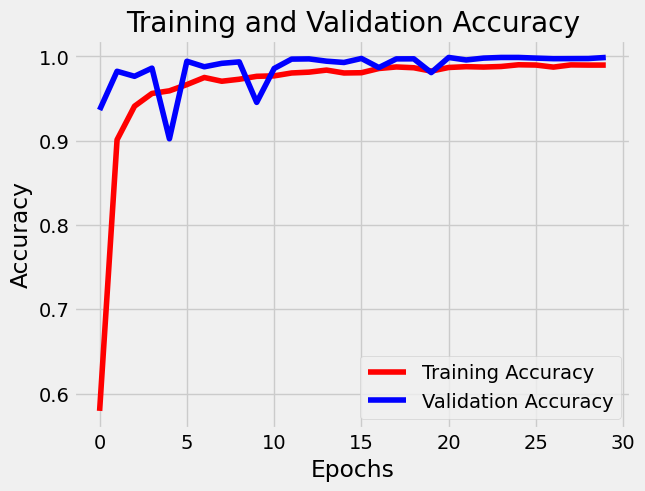

In [25]:
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

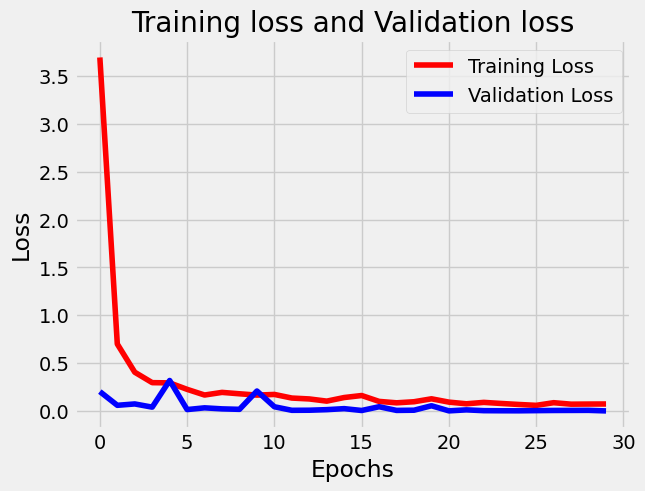

In [27]:
plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training loss and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [28]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming X_test and labels are defined
X_test = np.array(data)
X_test = X_test / 255  # Normalize the test data if needed

pred_probabilities = model.predict(X_test)
pred_classes = np.argmax(pred_probabilities, axis=-1)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred_classes) * 100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Data accuracy:  91.89231987331749


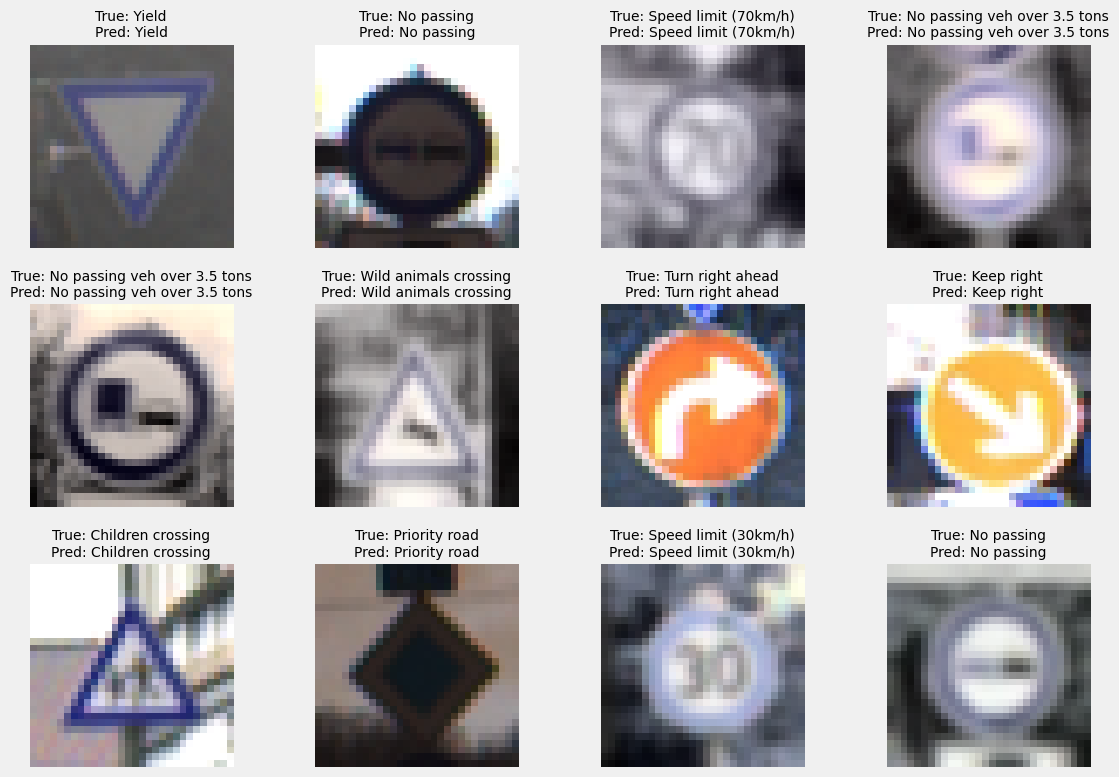

In [29]:
num_images_to_display = 12
random_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[idx])
    true_label = labels[idx]
    pred_label = pred_classes[idx]
    plt.title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}',fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
image = cv2.imread(data_dir + '/00006.png')
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
img_array = np.array(resize_image)
img_array = img_array.astype('float32')
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

# Post-process predictions
predicted_class = np.argmax(predictions[0])
print(f"Predicted Class Index: {classes[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Class Index: General caution
